# 1. Podcast Listening Time - EDA

The Dataset we will use today comes from Kaggle and is called **Predict Podcast Listening Time** which comes from *Kaggle Playground Series!*
https://www.kaggle.com/competitions/playground-series-s5e4

The task is to predict the listening time of a podcast, which is a numeric variable. We are thus doing a Regression model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px
from scipy.stats import ks_2samp, chi2_contingency, ttest_ind
import statsmodels.formula.api as smf
import scipy.stats as stats
import os
import math
from podcast_functions import *
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from umap import UMAP
from sklearn.linear_model import BayesianRidge
from sklearn.manifold import TSNE

# Load the data
dt_train = pd.read_csv(r"Data/train.csv")
dt_test = pd.read_csv(r"Data/test.csv")

In [2]:
print(f"Train set dimensions : {dt_train.shape}")
print(f"Test set dimensions : {dt_test.shape}")
dt_train.head()

Train set dimensions : (750000, 12)
Test set dimensions : (250000, 11)


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [3]:
# Build the summary table 
summary = (
    pd.DataFrame({
        "dtype"    : dt_train.dtypes,
        "n_unique" : dt_train.nunique(),
        "missing"  : dt_train.isna().mean()       
    })
    .assign(missing=lambda df: df["missing"].round(3))
    .sort_values("n_unique", ascending=False)
)

min_miss, max_miss = summary["missing"].min(), summary["missing"].max()

# Let's output the summary with a bit more style
styled_summary = (
    summary
      .style
      .format({"missing": "{:.1%}"})                                # 0.0 % format
      .map(colour_dtype, subset="dtype")                            # colour dtype text
      .map(lambda v: colour_gradient(v, "Reds", min_miss, max_miss),
           subset="missing")                                        # gradient on missing
      .set_properties(subset=["dtype"], **{"text-align": "left"})
)

styled_summary

,dtype,n_unique,missing
id,int64,750000,0.0%
Listening_Time_minutes,float64,42807,0.0%
Episode_Length_minutes,float64,12268,11.6%
Guest_Popularity_percentage,float64,10019,19.5%
Host_Popularity_percentage,float64,8038,0.0%
Episode_Title,object,100,0.0%
Podcast_Name,object,48,0.0%
Number_of_Ads,float64,12,0.0%
Genre,object,10,0.0%
Publication_Day,object,7,0.0%


In [4]:
target = "Listening_Time_minutes"
X_cat = ["Podcast_Name", "Genre", "Publication_Day", "Publication_Time", "Episode_Title","Episode_Sentiment"]
X_num = ["Episode_Length_minutes","Guest_Popularity_percentage","Number_of_Ads","Host_Popularity_percentage"]

In [5]:
dt_train["Genre"].value_counts()

Genre
Sports        87606
Technology    86256
True Crime    85059
Lifestyle     82461
Comedy        81453
Business      80521
Health        71416
News          63385
Music         62743
Education     49100
Name: count, dtype: int64

In [6]:
dt_train["Podcast_Name"].value_counts()

Podcast_Name
Tech Talks             22847
Sports Weekly          20053
Funny Folks            19635
Tech Trends            19549
Fitness First          19488
Business Insights      19480
Style Guide            19364
Game Day               19272
Melody Mix             18889
Criminal Minds         17735
Finance Focus          17628
Detective Diaries      17452
Crime Chronicles       17374
Athlete's Arena        17327
Fashion Forward        17280
Tune Time              17254
Business Briefs        17012
Lifestyle Lounge       16661
True Crime Stories     16373
Sports Central         16191
Digital Digest         16171
Humor Hub              16144
Mystery Matters        16002
Comedy Corner          15927
Joke Junction          15074
Wellness Wave          15009
Sport Spot             14778
Gadget Geek            14770
Home & Living          14686
Laugh Line             14673
Life Lessons           14464
World Watch            14043
Sound Waves            13928
Global News            13649
M

In [7]:
dt_train["Episode_Title"].value_counts()

Episode_Title
Episode 71    10515
Episode 62    10373
Episode 31    10292
Episode 61     9991
Episode 69     9864
              ...  
Episode 2      5134
Episode 25     5117
Episode 41     4965
Episode 37     4940
Episode 95     4838
Name: count, Length: 100, dtype: int64

Most of the categorical variables with high cardinality have a very balanced distribution, there aren't any podcast or any episode number that are under-represented, which is counter intuitive. I would have thought that the Episode 1 would have much more rows and they would decrease over with the number, but it isn't the case. 

The most frequent episode number is 71, which makes me think that the episode numbers are random and not really representative.

In [8]:
dt_train.loc[(dt_train["Podcast_Name"] == "Sport Spot") & (dt_train["Episode_Title"] == "Episode 32")]

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
17,17,Sport Spot,Episode 32,95.45,Sports,92.19,Thursday,Afternoon,70.29,2.0,Neutral,79.67749
12966,12966,Sport Spot,Episode 32,85.57,Sports,44.63,Monday,Evening,NaN,2.0,Neutral,38.34477
14682,14682,Sport Spot,Episode 32,67.38,Sports,57.21,Saturday,Afternoon,18.51,2.0,Negative,53.27600
18827,18827,Sport Spot,Episode 32,55.12,Sports,32.66,Monday,Night,17.18,0.0,Positive,31.03235
22157,22157,Sport Spot,Episode 32,90.74,Sports,90.84,Wednesday,Night,NaN,1.0,Neutral,63.59676
...,...,...,...,...,...,...,...,...,...,...,...,...
728432,728432,Sport Spot,Episode 32,54.70,Sports,97.12,Wednesday,Evening,NaN,3.0,Positive,46.84807
730173,730173,Sport Spot,Episode 32,71.18,Sports,82.97,Wednesday,Morning,82.51,0.0,Negative,54.36017
733659,733659,Sport Spot,Episode 32,62.56,Sports,28.02,Wednesday,Night,14.54,2.0,Positive,41.91386
737049,737049,Sport Spot,Episode 32,108.31,Sports,84.94,Thursday,Night,55.61,3.0,Positive,91.12612


In [9]:
dt_train["Episode_Title"] = dt_train["Episode_Title"].apply(lambda x: int(x[8:]))

It seems that a podcast can have multiple episodes with the same title.

## Target : Listening time

<Axes: xlabel='Listening_Time_minutes', ylabel='Count'>

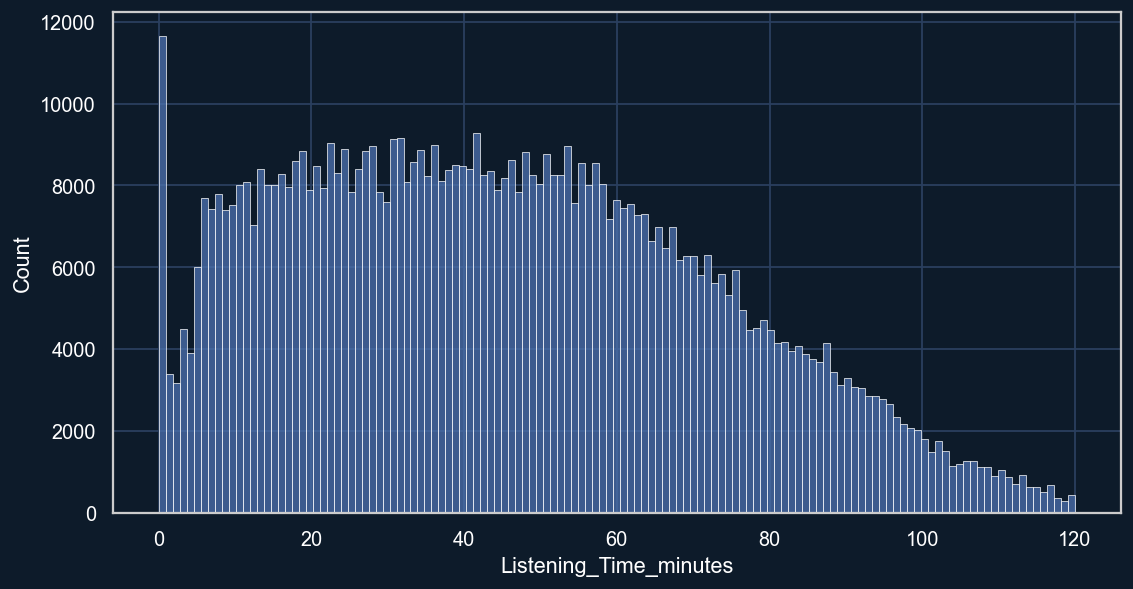

In [10]:
plt.figure(figsize=(10,5), dpi=130)
sns.histplot(dt_train[target].dropna())  

The distribution seems quite skewed toward the right. We can also notice a very tall bar at 0 minute, which means a non neglishible share of sessions have no listening at all (which might be due to failed playback, bots or logging quirks)

## Categorical Variables

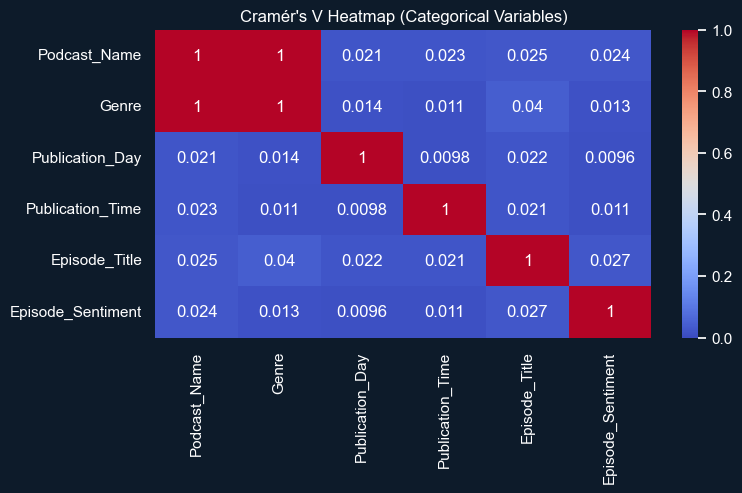

In [11]:
df = dt_train[X_cat]

# Create Cramér's V matrix
columns = df.columns
cramers_v_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), index=columns, columns=columns)

for col1 in columns:
    for col2 in columns:
        if col1 == col2:
            cramers_v_matrix.loc[col1, col2] = 1.0
        else:
            cramers_v_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Plot heatmap
plt.figure(figsize=(8,4))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title("Cramér's V Heatmap (Categorical Variables)")
plt.show()

Since the podcast name is a subcategory of the genre, it is not surprising that both variable are fully correlated. Keeping both of them would be redundant, I would choose to keep the podcast name since it's more granular than the Genre. The only case I would keep the genre is if we encounter now podcast names in the test set, which seems to not be the case:

In [12]:
all([elem in dt_test["Podcast_Name"].unique() for elem in dt_train["Podcast_Name"].unique()])

True

In [13]:
anova_results = []
for x in X_cat:
    filtered_df = dt_train[[x, target]].dropna()
    groups = [group[target].values for name, group in filtered_df.groupby(x)]
    f_stat, p_value = stats.f_oneway(*groups)
    anova_results.append({'feature': x,'f_stats':f_stat,'p_value': p_value})

anova_df = pd.DataFrame(anova_results)
anova_df = anova_df.sort_values(by='p_value')

anova_df['n_categories'] = anova_df['feature'].apply(lambda f: dt_train[f].nunique())
anova_df['eta_squared'] = anova_df['feature'].apply(lambda f: compute_eta_squared(dt_train, f, target))
anova_df = anova_df.sort_values(by='eta_squared', ascending=False)
anova_df

,feature,f_stats,p_value,n_categories,eta_squared
4,Episode_Title,44.384362,0.000000e+00,100,0.005825
0,Podcast_Name,42.095208,0.000000e+00,48,0.002631
5,Episode_Sentiment,586.007119,5.000200e-255,3,0.001560
3,Publication_Time,151.767360,2.479230e-98,4,0.000607
1,Genre,45.482308,1.467947e-82,10,0.000545
2,Publication_Day,40.510059,1.270200e-49,7,0.000324


The results of our ANOVA, especially the p_values show that every categorical variable are significant. However, the small values of eta_squared show that their impact are minimal. For example, the highest variance is by the "Episode Title" which explains only 0.58% of the variance !

In conclusion : Every factor passes the significance test, but none moves the needle much on its own.

## Numeric Variables

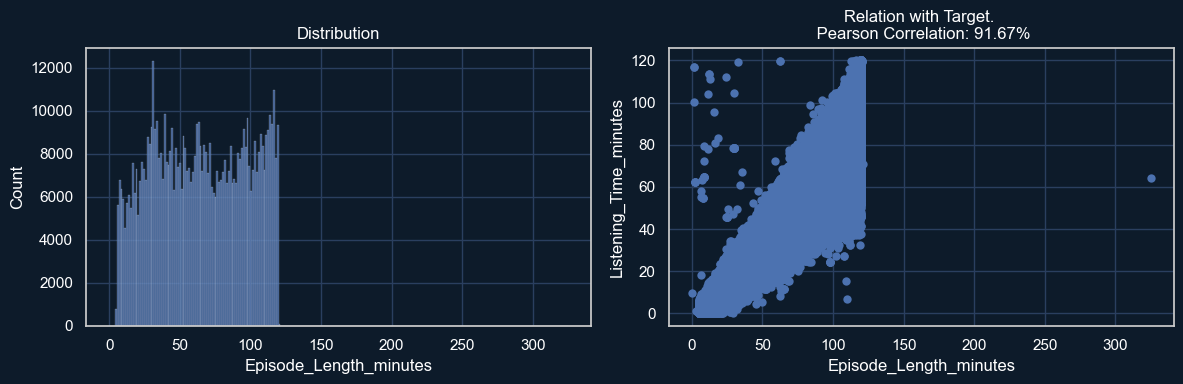

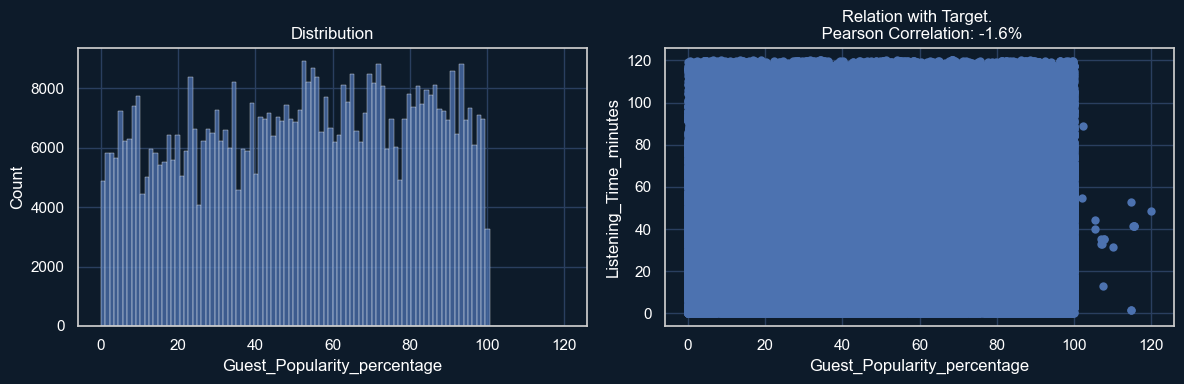

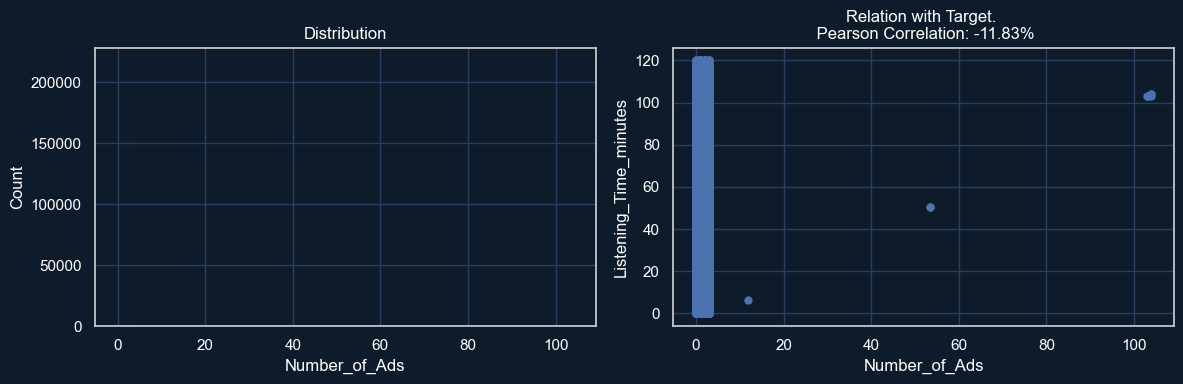

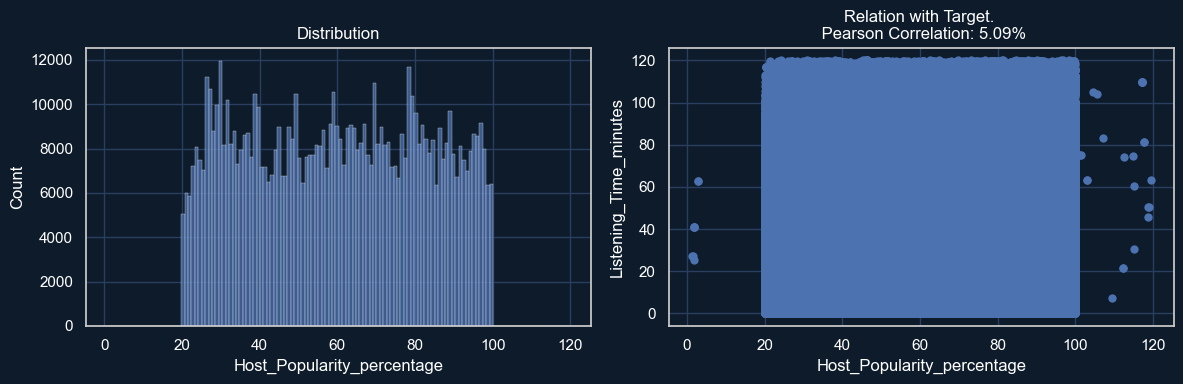

In [14]:
for x in X_num:
    # Create subplots: 1 row, 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # First subplot: histogram
    sns.histplot(dt_train[x].dropna(), ax=axes[0])  
    axes[0].set_title("Distribution")

    # Second subplot: scatterplot
    sns.scatterplot(x=x, y="Listening_Time_minutes",
                    sizes=(1, 8), linewidth=0,
                    data=dt_train, ax=axes[1])
    axes[1].set_title(f"Relation with Target. \n Pearson Correlation: {round(100*dt_train[x].corr(dt_train[target]),2)}%")

    # Display the plots
    plt.tight_layout()
    plt.show()

The number of ads shows some extremes outliers for a few observations

In [15]:
dt_train["Number_of_Ads"].value_counts()

Number_of_Ads
0.00      217592
1.00      214069
3.00      160173
2.00      158156
103.25         2
53.37          1
103.91         1
103.00         1
53.42          1
103.75         1
12.00          1
103.88         1
Name: count, dtype: int64

We are going to cap the number of ads to 3 as the other values seem to be errors

In [16]:
max_ads = 3
dt_train.loc[dt_train["Number_of_Ads"] > max_ads,["Number_of_Ads"]] = max_ads

We can also see that (outside of some outliers) the relation between the Target (Listening Time) and the Episode Length is linear but heteroscedastic, which means that the variance increase as the values increase. We are going to remove the few outlier because it seems to be a very rare unique case.

The Guest popularity percentage seems to have no relation with the Target (or very less obvious). There are also a few values over 100, which are probably mistakes

In [17]:
# Remove outliers
x = "Episode_Length_minutes"
ep_len =  dt_train[x]
desc = ep_len.describe(percentiles=[.001,.01,.1, .25, .5, .75, .9,.99,.999])
Q3 = desc["75%"]
Q1 = desc["25%"]
IQ = Q3 - Q1
IQ_filter = ((ep_len > Q1 - 1.5 * IQ) & (ep_len < Q3 + 1.5 * IQ))|ep_len.isna()
IQ_filter.value_counts()

Episode_Length_minutes
True     749999
False         1
Name: count, dtype: int64

In [18]:
#There is literally one outlier, we are going to remove it
dt_train[~IQ_filter]

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
101637,101637,Home & Living,16,325.24,Lifestyle,50.69,Tuesday,Afternoon,15.01,0.0,Positive,64.31981


In [19]:
dt_train = dt_train[IQ_filter].copy()

Now that we clean the data, we can analyze the Data more deeply. The triangle shape of the scatter plot strongly shows a relation between the two variables. Let's frame the overall relations between them with quantile regressions.

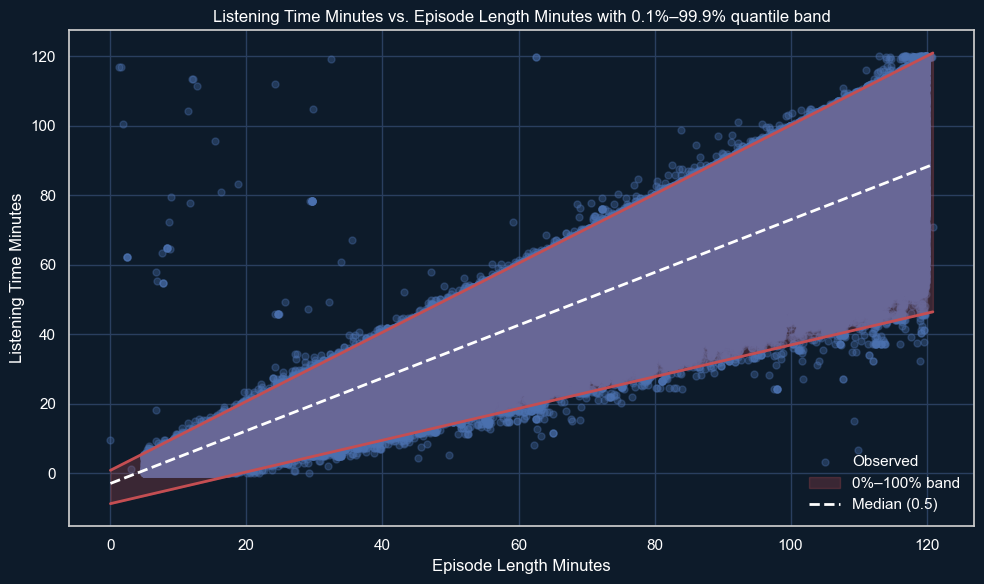

In [20]:
fig, ax, qr_models = plot_quantile_regression_band(
    dt_train,
    x="Episode_Length_minutes",
    y="Listening_Time_minutes",
    qs=(0.001, 0.50, 0.999)
)
plt.show()

Just the Episode Length seems to explain the Listening time (target) a lot already, let's try a simple regression to see the RMSE

In [30]:
dt_lr = dt_train.loc[~dt_train['Episode_Length_minutes'].isna()]
# Create and train model
model_lr = LinearRegression()
model_lr.fit(dt_lr[['Episode_Length_minutes']], dt_lr[target])

# Print results
print("Intercept:", round(model_lr.intercept_,2))
print("Coefficient:", round(model_lr.coef_[0],2))

preds = (model_lr.intercept_ + model_lr.coef_[0] * dt_lr['Episode_Length_minutes'])
residuals = dt_lr[target] - preds
rmse_lr = np.sqrt(np.mean(residuals**2))
print("")
print("RMSE:", round(rmse_lr,2))

Intercept: -3.18
Coefficient: 0.76

RMSE: 10.89


## Missing Values

We saw earlier that two variables had missing values we will see if they are MCAR (Missing Completely at Random), MAR (Missing at Random) or NMAR (nor Missing at Random)

In [44]:
dt_train["missing_Guest_Popularity"] = dt_train["Guest_Popularity_percentage"].isnull().astype(bool)
dt_train["missing_Episode_Length"] = dt_train["Episode_Length_minutes"].isnull().astype(bool)

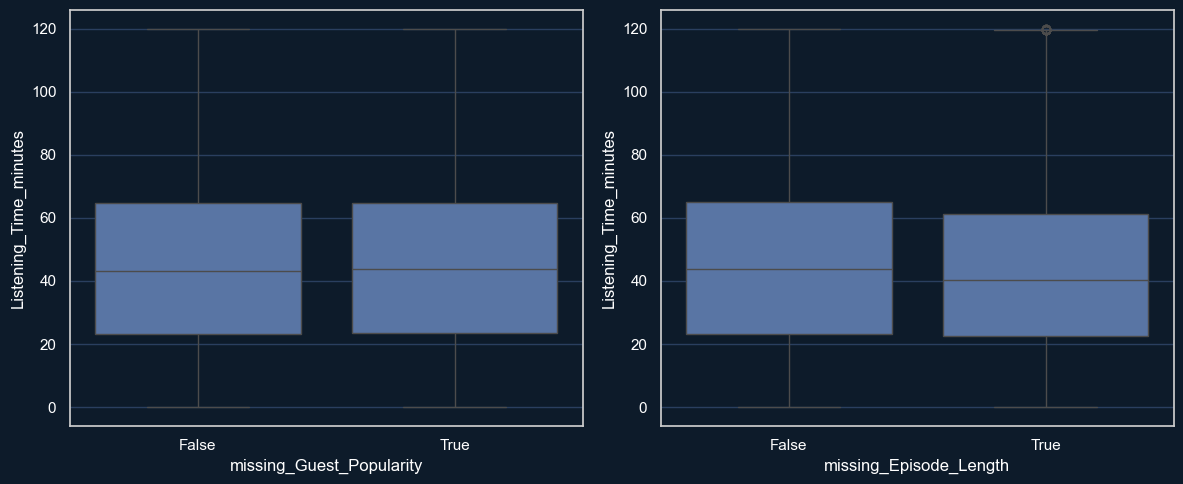

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(x="missing_Guest_Popularity", y=target, data=dt_train, ax=axes[0])
sns.boxplot(x="missing_Episode_Length", y=target, data=dt_train, ax=axes[1])

plt.tight_layout()
plt.show() 

In [46]:
for x  in ["missing_Guest_Popularity","missing_Episode_Length"]:
    print(x)
    print("")
    # Chi-squared test for categorical variables
    for col in X_cat:
        contingency = pd.crosstab(dt_train[col], dt_train[x])
        chi2, p, _, _ = chi2_contingency(contingency)
        print(f"{col} vs {x}: p-value = {p:.4f}")

    # t-test for numerical vs missingness
    t1 = dt_train[dt_train[x] == 1]["Listening_Time_minutes"]
    t2 = dt_train[dt_train[x] == 0]["Listening_Time_minutes"]
    t_stat, p = ttest_ind(t1, t2, nan_policy='omit')
    print(f"Listening_Time vs {x}: p-value = {p:.4f}")
    print("")
    
contingency = pd.crosstab(dt_train["missing_Guest_Popularity"], dt_train["missing_Episode_Length"])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"missing_Guest_Popularity vs missing_Episode_Length: p-value = {p:.4f}")

missing_Guest_Popularity

Podcast_Name vs missing_Guest_Popularity: p-value = 0.0000
Genre vs missing_Guest_Popularity: p-value = 0.0000
Publication_Day vs missing_Guest_Popularity: p-value = 0.0000
Publication_Time vs missing_Guest_Popularity: p-value = 0.0000
Episode_Title vs missing_Guest_Popularity: p-value = 0.0000
Episode_Sentiment vs missing_Guest_Popularity: p-value = 0.0557
Listening_Time vs missing_Guest_Popularity: p-value = 0.0132

missing_Episode_Length

Podcast_Name vs missing_Episode_Length: p-value = 0.0000
Genre vs missing_Episode_Length: p-value = 0.0000
Publication_Day vs missing_Episode_Length: p-value = 0.0000
Publication_Time vs missing_Episode_Length: p-value = 0.0000
Episode_Title vs missing_Episode_Length: p-value = 0.0000
Episode_Sentiment vs missing_Episode_Length: p-value = 0.0000
Listening_Time vs missing_Episode_Length: p-value = 0.0000

missing_Guest_Popularity vs missing_Episode_Length: p-value = 0.0000


Most of the p values are very close to 0, so it is very unlikely that our two variables are MCAR. We will test our algorithm with Gradient Boosting, so we will let these missing values as they are, but it is something that we should keep in mind

## Latent Structure

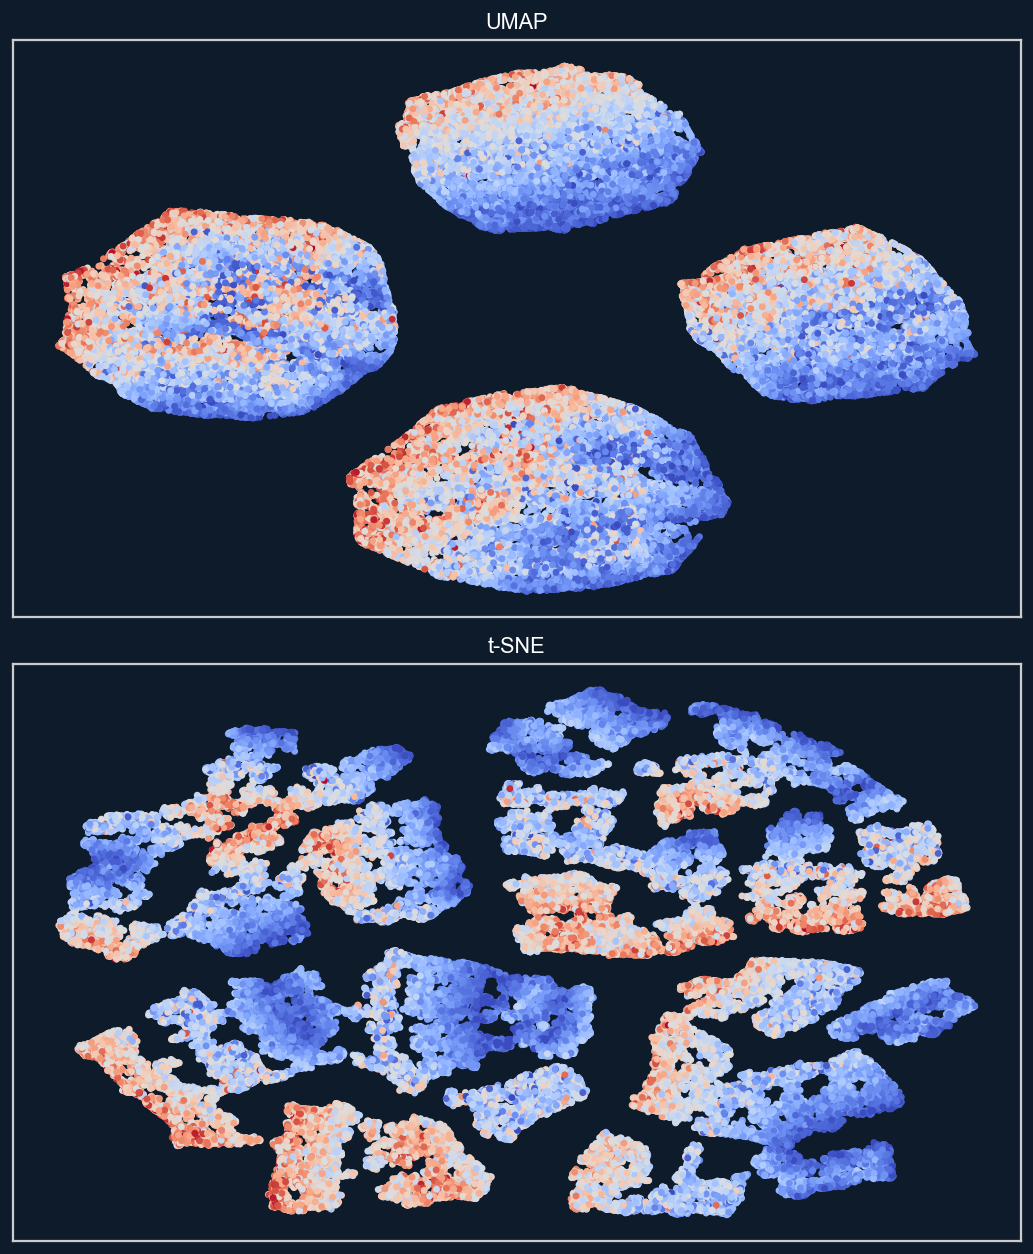

In [50]:
rng = np.random.RandomState(SEED)
N_SAMPLE = 75000
sample_idx = rng.choice(len(dt_train), size=N_SAMPLE, replace=False)
X  = dt_train.iloc[sample_idx][X_num + X_cat]
y  = dt_train.iloc[sample_idx][target]    

# ---------- encoders, imputer, selector ----------------------
enc = ColumnTransformer(
        transformers=[
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), X_cat),
            ("num", "passthrough", X_num)],
        remainder="drop", sparse_threshold=0
)
iter_imp = IterativeImputer(estimator=BayesianRidge(),
                            max_iter=100,
                            tol=1e-2,
                            random_state=3)

# keep only the numeric block (last len(X_num) columns) after imputation
pick_numeric = FunctionTransformer(lambda Z: Z[:, -len(X_num):], validate=False,
                                   feature_names_out="one-to-one")
scaler = StandardScaler()

# ------------------------ pipeline ----------------------------
pipe = Pipeline([
        ("encode", enc),
        ("impute", iter_imp),
        ("pick_numeric", pick_numeric),  
        ("scale", scaler)
])

# ---------------- fit / transform ----------------------------
pipe.fit(X)
umap = UMAP(random_state=None)
X_numeric_imputed_scaled = pipe.transform(X)
emb_umap = umap.fit_transform(X_numeric_imputed_scaled)

tsne = TSNE(n_components=2, perplexity=100, init="random",
            random_state=SEED, method="barnes_hut")
emb_tsne = tsne.fit_transform(X_numeric_imputed_scaled)

# ------------------------ plot -------------------------------
fig, (ax1, ax2) = plt.subplots(
    nrows=2, ncols=1,
    figsize=(10, 12), dpi=130,
    gridspec_kw={'hspace': 0.08}   
)

ax1.scatter(emb_umap[:, 0], emb_umap[:, 1], c=y, cmap="coolwarm", s=8)
ax2.scatter(emb_tsne[:, 0], emb_tsne[:, 1], c=y, cmap="coolwarm", s=8)

ax1.set_title("UMAP")
ax2.set_title("t-SNE")

for ax in (ax1, ax2):
    ax.set_xticks([]); ax.set_yticks([])

plt.show()


For UMAP, we can see clearly distinguish four "islands" with smooth color gradients inside each island, indicating the target varies smoothly along the manifold and that neighbor based models should capture signal.

For t-SNE, we can see smaller forms more spread everywhere with the target being more homogeneous in each part.

## Check Potential Drift between Train and Test Sets

Since we didn't do the split the set ourselves, it would be interesting to see if there is any drift between the train set and the test set

In [48]:
# Kolmogorov–Smirnov test for numeric variables
for col in X_num:
    stat, p = ks_2samp(dt_train[col].dropna(), dt_test[col].dropna())
    print(f"{col}: p={p:.4f}") 
print("")

# Chi Square test for Categorical Variables
for col in X_cat:
    train_counts = dt_train[col].value_counts(normalize=True)
    test_counts = dt_test[col].value_counts(normalize=True)
    combined = pd.concat([train_counts, test_counts], axis=1).fillna(0)
    stat, p, _, _ = chi2_contingency(combined.values)
    print(f"{col}: p={p:.4f}")

Episode_Length_minutes: p=0.5667
Guest_Popularity_percentage: p=0.3455
Number_of_Ads: p=0.8941
Host_Popularity_percentage: p=0.0526

Podcast_Name: p=1.0000
Genre: p=1.0000
Publication_Day: p=1.0000
Publication_Time: p=1.0000
Episode_Title: p=1.0000
Episode_Sentiment: p=1.0000


For every test, the p values are above the threshold, so we fail to reject the null hypothesis. We detect no drift between the train and the test set for any variable.

We are now ready to move to the Modeling part in the [Next Notebook](2_Podcast_ML.ipynb)